In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Movie similarity/movies.csv')

In [ ]:
df.head()

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [ ]:
df['plot'] = df['wiki_plot'] + '\n' + df['imdb_plot']

In [ ]:
old_df = df
df = df.drop(['wiki_plot', 'imdb_plot', 'rank'], axis = 1)

In [ ]:
def tokenize_stem(plot):
  stemmer = SnowballStemmer('english')
  sent_token = [sent for sent in nltk.sent_tokenize(plot)]
  word_token = [word for word in nltk.word_tokenize(sent_token[0])]
  filter_token = [w for w in word_token if re.search('[a-zA-Z]', w)]
  stem = [stemmer.stem(f) for f in filter_token]
  return stem

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.02, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_stem,
                                 ngram_range=(1,3))

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['plot'].apply(lambda x: np.str_(x)))
tfidf_matrix

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


<100x218 sparse matrix of type '<class 'numpy.float64'>'
	with 627 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
km_clf = KMeans(n_clusters = 10)
km_clf.fit(tfidf_matrix)
clusters = km_clf.labels_.tolist()
df['label'] = clusters
# df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df.label.value_counts()

5    31
9    13
2    10
6     8
1     8
3     7
8     7
4     6
0     5
7     5
Name: label, dtype: int64

In [ ]:
cosine_distance = cosine_similarity(tfidf_matrix, tfidf_matrix)
similarity_distance = 1 - cosine_similarity(tfidf_matrix, tfidf_matrix)

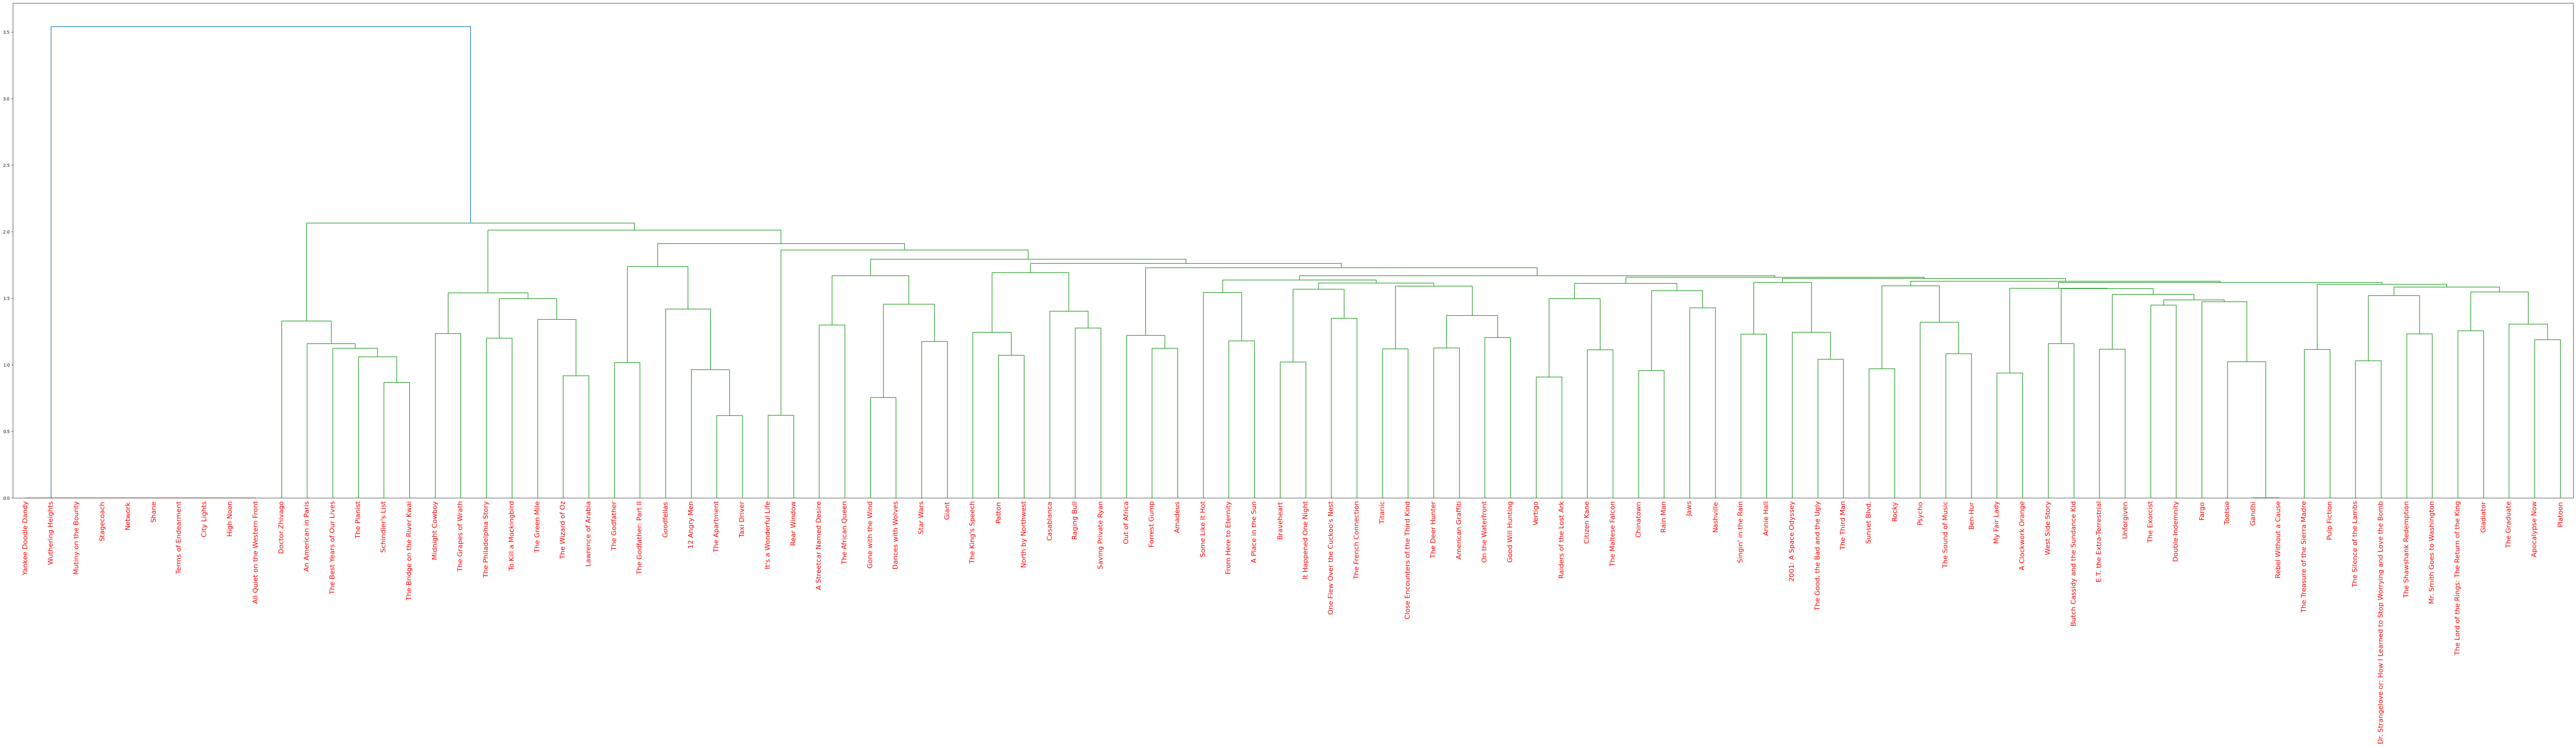

In [ ]:
mergings = linkage(similarity_distance, method='complete')

dendrogram_ = dendrogram(mergings,
               labels=[x for x in df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

In [ ]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [ ]:
m = 'The Godfather'

index = indices[m]
similarity_score = list(enumerate(cosine_distance[index]))
sorted_similarity = sorted(similarity_score, key= lambda x: x[1], reverse = True)
top10 = sorted_similarity[1:11]
similar_movies = [df['title'][i[0]] for i in top10]
similar_movies

['The Godfather: Part II',
 'Goodfellas',
 'Taxi Driver',
 'Jaws',
 '12 Angry Men',
 'The Apartment',
 "Singin' in the Rain",
 'The Maltese Falcon',
 'Giant',
 'Gone with the Wind']